<a href="https://colab.research.google.com/github/codingwithac/algorithms-and-data-structures/blob/main/Computer%20Vision/applications/generative%20deep%20learning/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from google.colab import files
import keras.utils as image
import matplotlib.pyplot as plt

# Discriminator network

A discriminator model that takes as input a canditate image (real or synthetic) and classifies it into one of two classes: fake image or real image.

In [11]:
def discriminator(shape=(28,28,1)):
  # define the shape of the inputs
  inputs = keras.Input(shape=shape)
  # some conv layers with LeakyReLU activation fcts
  x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(inputs)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  # flatten layer
  x = keras.layers.Flatten()(x)
  # dropout
  x = keras.layers.Dropout(rate=0.2)(x)
  # output layer
  outputs = keras.layers.Dense(units=1, activation="sigmoid")(x)

  return keras.Model(inputs=inputs, outputs=outputs, name="discriminator")

In [12]:
# create the discriminator
discriminator = discriminator()
# print its summary
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_1 (Dropout)         (None, 6272)            

# Generator network

A generator model that turns a vector (from the latent space) into a candidate image.

In [13]:
def generator(latent_dim=128):
  # the latent space will be made of 128-dimensional vectors
  inputs = keras.Input(shape=(latent_dim,))
  # same nr. of coefficients we had at the the level of the Flatten layer in the discriminator
  x = keras.layers.Dense(units=7 *7 *128)(inputs)
  # revert the Flatten layer of discriminator
  x = keras.layers.Reshape(target_shape=(7,7,128))(x)
  # some Conv2DTranspose layer to revert the Conv2D layers of the discriminator
  # we also use LeakyReLU as activation function
  x = keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="same")(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  x = keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="same")(x)
  x = keras.layers.LeakyReLU(alpha=0.2)(x)
  # the output ends up with a shape of (28,28,1)
  outputs = keras.layers.Conv2D(filters=1, kernel_size=5, padding="same", activation="sigmoid")(x)

  return keras.Model(inputs=inputs, outputs=outputs, name="generator")

In [14]:
# create the generator network
generator = generator()
# print its summary
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 256)      295168    
 ranspose)                                               

# GAN

A GAN network that chains the generator and the discriminator. When trained, this model will move the generator in a direction that improves its ability to fool the discriminator.
Randomly sampled points from the latent space are turned into a classification decision (fake or real) and  it is meant to be trained with labels that are always “these are real images.” So training gan will update the weights of generator in a way that makes discriminator more likely to predict “real” when looking at fake images.


In [15]:
class GAN(keras.Model):

  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    # set the discrimator, generator, the latent dimension and the metrics
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    # set the optimizers of the generator and discriminator networks
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    # set the loss function
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    # sample random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    # decode the random points to fake images
    generated_images = self.generator(random_latent_vectors)
    # combine fake and real images
    combined_images = tf.concat([generated_images, real_images], axis=0)
    # create the labels(1=fake; 0=real)
    labels = tf.concat([tf.ones((batch_size,1)), tf.zeros((batch_size, 1))], axis=0)
    # add noise to the labels
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # train the discriminator network
    with tf.GradientTape() as tape:
      # get the predictions
      predictions = self.discriminator(combined_images)
      # calculate the loss
      d_loss = self.loss_fn(labels, predictions)
    # get the gradients
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    # optimize the weights of the discriminator network
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))


    # sample new random points in the latent space
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    # create "fake" labels that indicate that these are real images although they are fake
    misleading_labels = tf.zeros((batch_size, 1))

    # train the generator
    with tf.GradientTape() as tape:
      # get the predictions
      predictions = self.discriminator(self.generator(random_latent_vectors))
      # calculate the loss
      g_loss = self.loss_fn(misleading_labels, predictions)
    # get the gradients
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    # optimize the weights of the generator network
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # update the loss metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    # print them
    return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}



# Callback

In [16]:
class GANCallback(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    # sample random points
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
    # generate images
    generated_images = self.model.generator(random_latent_vectors)
    # prepare them
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f"/content/drive/MyDrive/GAN Network/generated_img_{epoch:03d}_{i}.png")



# Train

In [17]:
# load the MNIST dataset; note that we do not need the labels
(x_train, _), (x_test, _ ) = keras.datasets.mnist.load_data()

# concatenate train & test image datasets
mnist_digits = np.concatenate([x_train, x_test], axis=0)

# normalize the data
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [18]:
# create the GAN
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=128)

# compile GAN
gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy())

# start the training proces
gan.fit(mnist_digits, epochs=50, callbacks=[GANCallback(num_img=10, latent_dim=128)])

Epoch 1/50
2188/2188 [==============================] - 42s 18ms/step - d_loss: 0.6280 - g_loss: 0.8769
Epoch 2/50
2188/2188 [==============================] - 38s 17ms/step - d_loss: 0.6544 - g_loss: 0.8569
Epoch 3/50
2188/2188 [==============================] - 38s 17ms/step - d_loss: 0.6000 - g_loss: 0.9676
Epoch 4/50
2188/2188 [==============================] - 38s 17ms/step - d_loss: 0.6002 - g_loss: 0.9597
Epoch 5/50
2188/2188 [==============================] - 38s 17ms/step - d_loss: 0.6305 - g_loss: 0.8932
Epoch 6/50
2188/2188 [==============================] - 39s 18ms/step - d_loss: 0.6420 - g_loss: 0.8537
Epoch 7/50
2188/2188 [==============================] - 38s 17ms/step - d_loss: 0.6467 - g_loss: 0.8366
Epoch 8/50
2188/2188 [==============================] - 38s 17ms/step - d_loss: 0.6432 - g_loss: 0.8425
Epoch 9/50
2188/2188 [==============================] - 38s 17ms/step - d_loss: 0.6375 - g_loss: 0.8502
Epoch 10/50
2188/2188 [==============================] - 38s 17m

# Save the weights

In [22]:
gan.save_weights("/content/drive/MyDrive/GAN Network/gan.keras")

# Visualize

In [19]:
def print():
  uploaded = files.upload()
  fig = plt.figure(figsize=(10,10))
  for num, fn in enumerate(uploaded.keys()):
    path = fn
    img = image.load_img(path, target_size=(100,100))
    plt.subplot(1,len(uploaded),num+1) # <-------
    plt.axis('off')
    plt.imshow(img)

Let's visualize the images of generated after epoch 0:

Saving generated_img_000_9.png to generated_img_000_9 (1).png
Saving generated_img_000_8.png to generated_img_000_8 (1).png
Saving generated_img_000_7.png to generated_img_000_7 (1).png
Saving generated_img_000_6.png to generated_img_000_6 (1).png
Saving generated_img_000_5.png to generated_img_000_5 (1).png
Saving generated_img_000_4.png to generated_img_000_4 (1).png
Saving generated_img_000_3.png to generated_img_000_3 (1).png
Saving generated_img_000_2.png to generated_img_000_2 (1).png
Saving generated_img_000_1.png to generated_img_000_1 (1).png
Saving generated_img_000_0.png to generated_img_000_0 (1).png


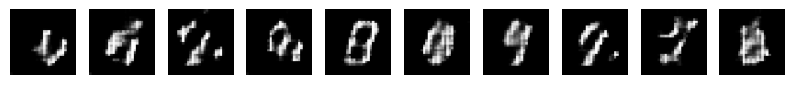

In [20]:
print()

Let's visualize the images of generated after epoch 10:

Saving generated_img_010_9.png to generated_img_010_9 (1).png
Saving generated_img_010_8.png to generated_img_010_8 (1).png
Saving generated_img_010_7.png to generated_img_010_7 (1).png
Saving generated_img_010_6.png to generated_img_010_6 (1).png
Saving generated_img_010_5.png to generated_img_010_5 (1).png
Saving generated_img_010_4.png to generated_img_010_4 (1).png
Saving generated_img_010_3.png to generated_img_010_3 (1).png
Saving generated_img_010_2.png to generated_img_010_2 (1).png
Saving generated_img_010_1.png to generated_img_010_1 (1).png
Saving generated_img_010_0.png to generated_img_010_0 (1).png


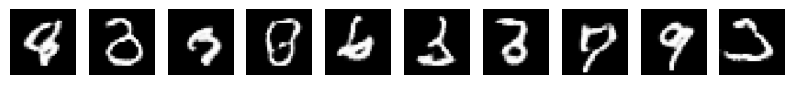

In [21]:
print()

After epoch 20:

Saving generated_img_020_9.png to generated_img_020_9 (1).png
Saving generated_img_020_8.png to generated_img_020_8 (1).png
Saving generated_img_020_7.png to generated_img_020_7 (1).png
Saving generated_img_020_6.png to generated_img_020_6 (1).png
Saving generated_img_020_5.png to generated_img_020_5 (1).png
Saving generated_img_020_4.png to generated_img_020_4 (1).png
Saving generated_img_020_3.png to generated_img_020_3 (1).png
Saving generated_img_020_2.png to generated_img_020_2 (1).png
Saving generated_img_020_1.png to generated_img_020_1 (1).png
Saving generated_img_020_0.png to generated_img_020_0 (1).png


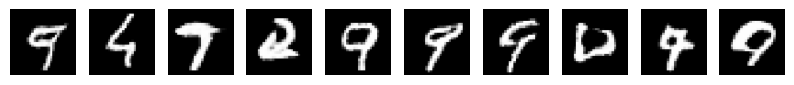

In [22]:
print()

After epoch 30:

Saving generated_img_030_9.png to generated_img_030_9 (1).png
Saving generated_img_030_8.png to generated_img_030_8 (1).png
Saving generated_img_030_7.png to generated_img_030_7 (1).png
Saving generated_img_030_6.png to generated_img_030_6 (1).png
Saving generated_img_030_5.png to generated_img_030_5 (1).png
Saving generated_img_030_4.png to generated_img_030_4 (1).png
Saving generated_img_030_3.png to generated_img_030_3 (1).png
Saving generated_img_030_2.png to generated_img_030_2 (1).png
Saving generated_img_030_1.png to generated_img_030_1 (1).png
Saving generated_img_030_0.png to generated_img_030_0 (1).png


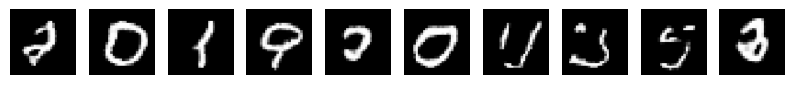

In [23]:
print()

After epoch 40:

Saving generated_img_040_9.png to generated_img_040_9 (1).png
Saving generated_img_040_8.png to generated_img_040_8 (1).png
Saving generated_img_040_7.png to generated_img_040_7 (1).png
Saving generated_img_040_6.png to generated_img_040_6 (1).png
Saving generated_img_040_5.png to generated_img_040_5 (1).png
Saving generated_img_040_4.png to generated_img_040_4 (1).png
Saving generated_img_040_3.png to generated_img_040_3 (1).png
Saving generated_img_040_2.png to generated_img_040_2 (1).png
Saving generated_img_040_1.png to generated_img_040_1 (1).png
Saving generated_img_040_0.png to generated_img_040_0 (1).png


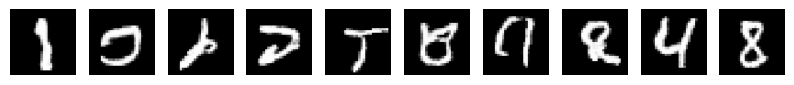

In [24]:
print()

After epoch 50:

Saving generated_img_049_9.png to generated_img_049_9 (4).png
Saving generated_img_049_8.png to generated_img_049_8 (2).png
Saving generated_img_049_7.png to generated_img_049_7 (2).png
Saving generated_img_049_6.png to generated_img_049_6 (2).png
Saving generated_img_049_5.png to generated_img_049_5 (2).png
Saving generated_img_049_4.png to generated_img_049_4 (2).png
Saving generated_img_049_3.png to generated_img_049_3 (2).png
Saving generated_img_049_2.png to generated_img_049_2 (1).png
Saving generated_img_049_1.png to generated_img_049_1 (1).png
Saving generated_img_049_0.png to generated_img_049_0 (1).png


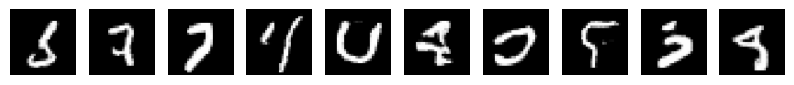

In [25]:
print()